In [145]:
import jax.numpy as jnp
import jax.scipy as jsp
from PIL import Image
import matplotlib.pyplot as plt
import jax

# Import images and convert to matrix 

In [171]:


img_1 = Image.open("images/img_1.png")
img_2 = Image.open("images/img_2.png")
img_3 = Image.open("images/img_3.png")
img_4 = Image.open("images/img_4.png")

img_1 = jnp.array(img_1)
img_1 = img_1[:,:,:3]
img_2 = jnp.array(img_2)
img_2 = img_2[:,:,:3]
img_3 = jnp.array(img_3)
img_3 = img_3[:,:,:3]
img_4 = jnp.array(img_4)
img_4 = img_4[:,:,:3]

# Normalize image for contrast and luminance

In [147]:
def to_grayscale(img):
    '''Converts an RGBA image to grayscale'''
    return jnp.mean(img, axis=2)

def normalize_lumincance(img):
    '''Normalizes the luminance values of an image so that the min value is 0 and the max value is 255'''
    image = img.astype(jnp.float32) 
    normalized = (image - jnp.min(image)) / (jnp.max(image) - jnp.min(image))
    normalized = normalized * 255
    return normalized.astype(jnp.uint8)

def resize_square(img, side_length):
    '''Resizes an image to a square with the specified side length'''
    return jax.image.resize(img, (side_length, side_length), method='bilinear')

(1190, 2320)


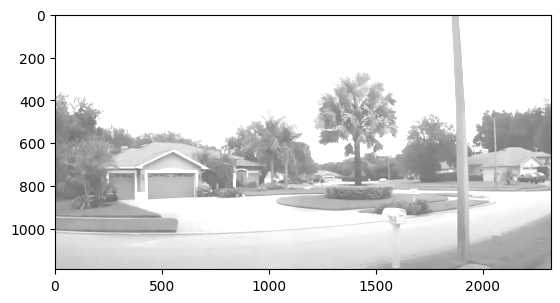

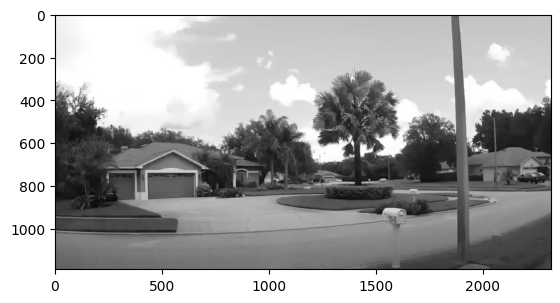

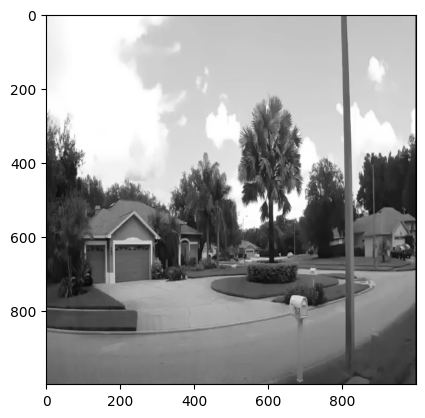

In [194]:

# convert to grayscale
img_gray = to_grayscale(img_1) + 100
print(img_gray.shape)
plt.imshow(img_gray , cmap='gray', vmin=0, vmax=255)
plt.show()

#normalize luminance
img_normalized = normalize_lumincance(img_gray)
plt.imshow(img_normalized , cmap='gray', vmin=0, vmax=255)
plt.show()

#resize
img_resized = resize_square(img_normalized, 1000)
plt.imshow(img_resized , cmap='gray', vmin=0, vmax=255)
plt.show()

img2_gray = to_grayscale(img_2)
img2_normalized = normalize_lumincance(img2_gray)
img2_resized = resize_square(img2_normalized, 1000)


img3_resized = resize_square(normalize_lumincance(to_grayscale(img_3)), 1000)
img4_resized = resize_square(normalize_lumincance(to_grayscale(img_4)), 1000)



# Calculate structural simmilarity index measure


(25, 200, 200)


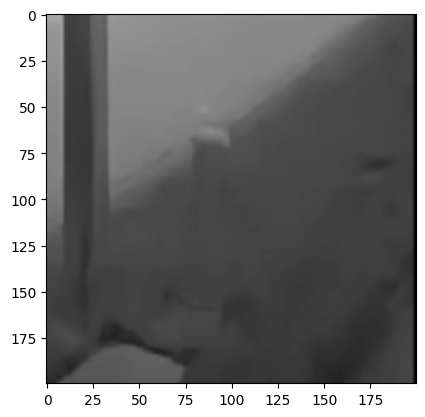

In [202]:

def get_tiles(img, subdiv=5):
    '''Splits an image into a grid of tiles'''
    tile_size = img.shape[0] // subdiv
    
    def slice_tile(i, j):
        start_indices = jnp.array([i * tile_size, j * tile_size])
        slice_sizes = jnp.array([tile_size, tile_size])
        return jax.lax.dynamic_slice(img, start_indices, slice_sizes)
    
    def generate_indices(subdiv):
        '''Helper function to generate all possible indices for the tiles'''
        i_indices = jnp.repeat(jnp.arange(subdiv), subdiv)
        j_indices = jnp.tile(jnp.arange(subdiv), subdiv)
        return jnp.stack((i_indices, j_indices), axis=-1)
    indices = generate_indices(subdiv)
    tiles = jax.vmap(lambda idx: slice_tile(idx[0], idx[1]))(indices)
    
    return jnp.stack(tiles)


tiles = get_tiles(img_resized)
print(tiles.shape)
plt.imshow(tiles[-1], cmap='gray', vmin=0, vmax=255)

# Get Structural Simmilarity Index Measure

In [196]:
def ssim(img_1, img_2, subdiv=10):
    def get_ssim_tile(img_1, img_2):
        mu_x = jnp.mean(img_1)
        mu_y = jnp.mean(img_2)
        sigma_x = jnp.std(img_1)
        sigma_y = jnp.std(img_2)
        sigma_xy = jnp.mean((img_1 - mu_x) * (img_2 - mu_y))
        
        c1 = 0.01
        c2 = 0.03
        
        ssim = (2 * mu_x * mu_y + c1) * (2 * sigma_xy + c2) / ((mu_x**2 + mu_y**2 + c1) * (sigma_x**2 + sigma_y**2 + c2))
        return ssim
    
    tiles_1 = get_tiles(img_1, subdiv)
    tiles_2 = get_tiles(img_2, subdiv)
    
    ssim_values = jax.vmap(get_ssim_tile)(tiles_1, tiles_2)
    
    return jnp.mean(ssim_values)

ssim_value = ssim(img_resized, img2_resized)
print("img1, img2",ssim_value)
ssim_value = ssim(img3_resized, img4_resized)
print("img3, img4",ssim_value)


img1, img2 0.84216624
img3, img4 0.66111654


In [193]:
def blur(img, window=50):
    x = jnp.linspace(-3, 3, window)
    window = jsp.stats.norm.pdf(x) * jsp.stats.norm.pdf(x[:, None])
    window = window / jnp.sum(window, keepdims=True)
    
    return jsp.signal.convolve2d(img, window, mode='same')

    

def mse(img_1, img_2):
    blur_img_1 = blur(img_1, 50)
    blur_img_2 = blur(img_2, 50)
    return jnp.mean((blur_img_1 - blur_img_2)**2)

img_1_blurred = blur(img_resized, 50)
mse_value = mse(img_resized, img2_resized)


def norm_mse(z, slope=80):
    return 1/(z/slope + 1)


print(norm_mse(mse_value))

0.7396
